In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from pathlib import PurePath
import os
import sys
import pickle
import scipy.sparse as sp
from scipy.sparse import linalg
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
torch.manual_seed(99)
np.random.seed(99)
if torch.cuda.is_available():
    device = torch.device('cpu')#'cuda:0')

In [5]:
torch.load(torch.load('../logs/baseline_v2/fancy-pyramid-5/best_model.pth'))

AttributeError: 'collections.OrderedDict' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [2]:
class StandardScaler:
    """
    Standard the input
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean

In [3]:
# class DataLoader(object):
#     def __init__(self, xs, ys, batch_size, pad_with_last_sample=True):
#         """
#         :param xs:
#         :param ys:
#         :param batch_size:
#         :param pad_with_last_sample: pad with the last sample to make number of samples divisible to batch_size.
#         """
#         self.batch_size = batch_size
#         self.current_ind = 0
#         if pad_with_last_sample:
#             num_padding = (batch_size - (len(xs) % batch_size)) % batch_size
#             x_padding = np.repeat(xs[-1:], num_padding, axis=0)
#             y_padding = np.repeat(ys[-1:], num_padding, axis=0)
#             xs = np.concatenate([xs, x_padding], axis=0)
#             ys = np.concatenate([ys, y_padding], axis=0)
#         self.size = len(xs)
#         self.num_batch = int(self.size // self.batch_size)
#         self.xs = xs
#         self.ys = ys

#     def shuffle(self):
#         permutation = np.random.permutation(self.size)
#         xs, ys = self.xs[permutation], self.ys[permutation]
#         self.xs = xs
#         self.ys = ys

#     def get_iterator(self):
#         self.current_ind = 0

#         def _wrapper():
#             while self.current_ind < self.num_batch:
#                 start_ind = self.batch_size * self.current_ind
#                 end_ind = min(self.size, self.batch_size * (self.current_ind + 1))
#                 x_i = self.xs[start_ind: end_ind, ...]
#                 y_i = self.ys[start_ind: end_ind, ...]
#                 yield (x_i, y_i)
#                 self.current_ind += 1

#         return _wrapper()

In [4]:
train_data = PurePath('../data/METR-LA/train.npz')
train_data = np.load(train_data)
xtrain = train_data['x']
ytrain = train_data['y']
x_offsets = train_data['x_offsets']
y_offsets = train_data['y_offsets']

In [5]:
print(train_data['x'].shape)

(23974, 12, 207, 2)


In [6]:
scaler = StandardScaler(mean=xtrain[..., 0].mean(), std=xtrain[..., 0].std())

In [7]:
# xtrain = xtrain[:5,]
# ytrain = ytrain[:5,]

In [8]:
print('xtrain:', xtrain.shape)
print('ytrain:', ytrain.shape)

xtrain: (23974, 12, 207, 2)
ytrain: (23974, 12, 207, 2)


In [9]:
batch_size = 64
pad_with_last_sample= True
current_ind = 0
size = len(xtrain)
print(size)

23974


In [10]:
num_padding = (batch_size - (len(xtrain) % batch_size)) % batch_size
print(num_padding)

26


In [11]:
print(xtrain[-1:].shape)

(1, 12, 207, 2)


In [12]:
x_padding = np.repeat(xtrain[-1:], num_padding, axis=0)
y_padding = np.repeat(ytrain[-1:], num_padding, axis=0)
print('x_padding: ', x_padding.shape)
print('y_padding: ', y_padding.shape)

x_padding:  (26, 12, 207, 2)
y_padding:  (26, 12, 207, 2)


In [13]:
xs = np.concatenate([xtrain, x_padding], axis=0)
ys = np.concatenate([ytrain, y_padding], axis=0)

In [14]:
print(xs.shape)

(24000, 12, 207, 2)


In [15]:
num_batch = int(size // batch_size)
print(num_batch)

374


In [16]:
xtrain = xs
ytrain = ys

In [17]:
print('xtrain:', xtrain.shape)
print('ytrain:', ytrain.shape)

xtrain: (24000, 12, 207, 2)
ytrain: (24000, 12, 207, 2)


In [18]:
def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

In [19]:
def asym_adj(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv = np.power(rowsum, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat = sp.diags(d_inv)
    return d_mat.dot(adj).astype(np.float32).todense()

In [20]:
sensor_ids, sensor_id_to_ind, adj_mx = load_pickle(PurePath('../data/sensor_graph/adj_mx.pkl'))

In [21]:
print(len(sensor_ids))
print(sensor_ids)

207
['773869', '767541', '767542', '717447', '717446', '717445', '773062', '767620', '737529', '717816', '765604', '767471', '716339', '773906', '765273', '716331', '771667', '716337', '769953', '769402', '769403', '769819', '769405', '716941', '717578', '716960', '717804', '767572', '767573', '773012', '773013', '764424', '769388', '716328', '717819', '769941', '760987', '718204', '718045', '769418', '768066', '772140', '773927', '760024', '774012', '774011', '767609', '769359', '760650', '716956', '769831', '761604', '717495', '716554', '773953', '767470', '716955', '764949', '773954', '767366', '769444', '773939', '774067', '769443', '767750', '767751', '767610', '773880', '764766', '717497', '717490', '717491', '717492', '717493', '765176', '717498', '717499', '765171', '718064', '718066', '765164', '769431', '769430', '717610', '767053', '767621', '772596', '772597', '767350', '767351', '716571', '773023', '767585', '773024', '717483', '718379', '717481', '717480', '717486', '7641

In [22]:
print(sensor_id_to_ind)

{'773869': 0, '767541': 1, '767542': 2, '717447': 3, '717446': 4, '717445': 5, '773062': 6, '767620': 7, '737529': 8, '717816': 9, '765604': 10, '767471': 11, '716339': 12, '773906': 13, '765273': 14, '716331': 15, '771667': 16, '716337': 17, '769953': 18, '769402': 19, '769403': 20, '769819': 21, '769405': 22, '716941': 23, '717578': 24, '716960': 25, '717804': 26, '767572': 27, '767573': 28, '773012': 29, '773013': 30, '764424': 31, '769388': 32, '716328': 33, '717819': 34, '769941': 35, '760987': 36, '718204': 37, '718045': 38, '769418': 39, '768066': 40, '772140': 41, '773927': 42, '760024': 43, '774012': 44, '774011': 45, '767609': 46, '769359': 47, '760650': 48, '716956': 49, '769831': 50, '761604': 51, '717495': 52, '716554': 53, '773953': 54, '767470': 55, '716955': 56, '764949': 57, '773954': 58, '767366': 59, '769444': 60, '773939': 61, '774067': 62, '769443': 63, '767750': 64, '767751': 65, '767610': 66, '773880': 67, '764766': 68, '717497': 69, '717490': 70, '717491': 71, '

In [23]:
df_ids_to_indx = pd.DataFrame(sensor_id_to_ind, index=['index'])

In [24]:
df_ids_to_indx.head()

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
index,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206


In [25]:
pd_adjmx = pd.DataFrame(adj_mx)
pd_adjmx.head()

,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.119804,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.000000,0.390955,0.000000,0.000000,0.0,0.000000,0.390457,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.717438,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,1.000000,0.633722,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.626464,1.000000,0.0,0.135197,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


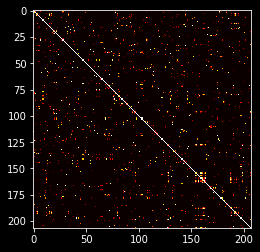

In [26]:
plt.imshow(adj_mx, cmap='hot', interpolation='nearest')
plt.show()

In [27]:
temp_adj = sp.coo_matrix(adj_mx)

In [28]:
temp_sparse = pd.DataFrame(temp_adj.toarray())
temp_sparse.head()


,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.119804,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.000000,0.390955,0.000000,0.000000,0.0,0.000000,0.390457,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.717438,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,1.000000,0.633722,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.626464,1.000000,0.0,0.135197,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
rowsum = np.array(temp_adj.sum(1)).flatten()
print(rowsum)

[4.8790474 3.8074965 4.7728834 6.3491626 6.529217  5.978633  2.5448685
 5.8831587 3.908402  1.9547358 2.9890707 3.6266563 6.577396  4.2766533
 4.20866   4.169542  6.612697  6.00738   2.2409236 5.634365  5.5093412
 2.5499327 3.6182978 2.7666893 4.8741946 3.356218  1.        3.9139664
 4.878662  3.3243592 2.0901759 1.8946577 5.387334  5.5656667 2.257032
 1.5289236 4.18594   5.3190236 5.7731876 5.766285  5.9297867 4.5902443
 4.5250587 3.1932726 3.4232037 1.5891383 1.2189673 4.577391  5.156733
 2.2376528 3.270173  1.7809134 3.153714  4.328876  5.7200537 5.984885
 2.4290106 3.8894944 4.4755545 3.5389197 2.8290563 2.6312385 3.8367918
 3.6214924 2.391692  1.2534679 1.5699569 3.065265  4.585918  4.0661435
 3.5900002 4.918135  2.3088005 2.4735792 5.1320534 3.633504  2.427967
 5.5080566 4.227985  3.3422134 6.41047   5.702085  4.0189047 3.4552138
 5.4822087 4.14094   2.5961277 4.3992176 5.0501523 3.5999427 1.6620762
 6.0069    1.4481485 4.1596856 5.2403245 2.2146904 5.5234118 4.3374615
 3.72856  

In [30]:
d_inv = np.power(rowsum, -1).flatten()
print(d_inv)


[0.20495804 0.26263976 0.20951696 0.15750109 0.15315773 0.16726232
 0.3929476  0.16997671 0.25585905 0.5115781  0.33455214 0.2757361
 0.15203585 0.2338277  0.23760532 0.2398345  0.15122423 0.16646191
 0.44624457 0.17748229 0.1815099  0.3921672  0.27637306 0.36144283
 0.2051621  0.2979544  1.         0.25549528 0.20497423 0.30080986
 0.47842863 0.52779984 0.18562058 0.179673   0.44305974 0.6540549
 0.23889498 0.18800443 0.17321454 0.17342189 0.16864014 0.21785332
 0.22099161 0.31315836 0.292124   0.62927186 0.82036656 0.21846506
 0.19392122 0.44689685 0.3057942  0.5615096  0.31708646 0.23100685
 0.17482354 0.16708758 0.41169026 0.25710282 0.223436   0.28257212
 0.35347477 0.38004917 0.26063442 0.27612925 0.41811407 0.79778665
 0.63696015 0.32623607 0.21805885 0.24593328 0.27855152 0.2033291
 0.43312535 0.4042725  0.19485378 0.27521643 0.4118672  0.18155223
 0.23651929 0.29920292 0.1559948  0.17537445 0.24882402 0.28941768
 0.18240823 0.24149105 0.38518906 0.22731315 0.19801383 0.2777822

In [31]:
d_inv[np.isinf(d_inv)] = 0.
print(d_inv)


[0.20495804 0.26263976 0.20951696 0.15750109 0.15315773 0.16726232
 0.3929476  0.16997671 0.25585905 0.5115781  0.33455214 0.2757361
 0.15203585 0.2338277  0.23760532 0.2398345  0.15122423 0.16646191
 0.44624457 0.17748229 0.1815099  0.3921672  0.27637306 0.36144283
 0.2051621  0.2979544  1.         0.25549528 0.20497423 0.30080986
 0.47842863 0.52779984 0.18562058 0.179673   0.44305974 0.6540549
 0.23889498 0.18800443 0.17321454 0.17342189 0.16864014 0.21785332
 0.22099161 0.31315836 0.292124   0.62927186 0.82036656 0.21846506
 0.19392122 0.44689685 0.3057942  0.5615096  0.31708646 0.23100685
 0.17482354 0.16708758 0.41169026 0.25710282 0.223436   0.28257212
 0.35347477 0.38004917 0.26063442 0.27612925 0.41811407 0.79778665
 0.63696015 0.32623607 0.21805885 0.24593328 0.27855152 0.2033291
 0.43312535 0.4042725  0.19485378 0.27521643 0.4118672  0.18155223
 0.23651929 0.29920292 0.1559948  0.17537445 0.24882402 0.28941768
 0.18240823 0.24149105 0.38518906 0.22731315 0.19801383 0.2777822

In [32]:
d_mat = sp.diags(d_inv)
print(d_mat)


  (0, 0)	0.20495804
  (1, 1)	0.26263976
  (2, 2)	0.20951696
  (3, 3)	0.15750109
  (4, 4)	0.15315773
  (5, 5)	0.16726232
  (6, 6)	0.3929476
  (7, 7)	0.16997671
  (8, 8)	0.25585905
  (9, 9)	0.5115781
  (10, 10)	0.33455214
  (11, 11)	0.2757361
  (12, 12)	0.15203585
  (13, 13)	0.2338277
  (14, 14)	0.23760532
  (15, 15)	0.2398345
  (16, 16)	0.15122423
  (17, 17)	0.16646191
  (18, 18)	0.44624457
  (19, 19)	0.17748229
  (20, 20)	0.1815099
  (21, 21)	0.3921672
  (22, 22)	0.27637306
  (23, 23)	0.36144283
  (24, 24)	0.2051621
  :	:
  (182, 182)	1.0
  (183, 183)	0.84783137
  (184, 184)	0.23409142
  (185, 185)	0.30952314
  (186, 186)	0.5782616
  (187, 187)	0.1605139
  (188, 188)	0.16181456
  (189, 189)	0.4786034
  (190, 190)	0.34135953
  (191, 191)	0.16885284
  (192, 192)	0.16476831
  (193, 193)	0.15851486
  (194, 194)	0.6364857
  (195, 195)	0.1258963
  (196, 196)	0.18410665
  (197, 197)	0.21257946
  (198, 198)	0.15020482
  (199, 199)	0.26717675
  (200, 200)	0.7916717
  (201, 201)	0.35796335
  (20

        0         1         2         3         4    5         6        7    \
0  0.204958  0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.00000   
1  0.000000  0.262640  0.102680  0.000000  0.000000  0.0  0.000000  0.10255   
2  0.000000  0.150315  0.209517  0.000000  0.000000  0.0  0.000000  0.00000   
3  0.000000  0.000000  0.000000  0.157501  0.099812  0.0  0.000000  0.00000   
4  0.000000  0.000000  0.000000  0.095948  0.153158  0.0  0.020706  0.00000   

   8    9    ...  197  198       199  200  201  202  203  204  205  206  
0  0.0  0.0  ...  0.0  0.0  0.024555  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  ...  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  ...  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  ...  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  ...  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 207 columns]


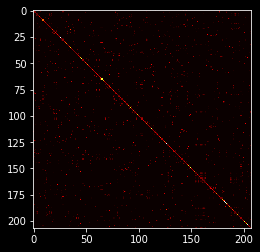

In [33]:
ad_mat = d_mat.dot(temp_adj).astype(np.float32).todense()
df_a = pd.DataFrame(ad_mat)
print(df_a.head(5))
plt.imshow(df_a, cmap='hot', interpolation='nearest')
plt.show()



In [34]:
adj = [asym_adj(adj_mx), asym_adj(np.transpose(adj_mx))]

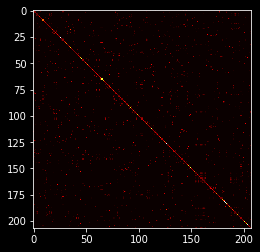

In [35]:
plt.imshow(adj[0], cmap='hot', interpolation='nearest')
plt.show()

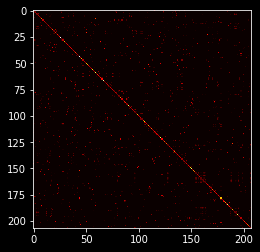

In [36]:
plt.imshow(adj[1], cmap='hot', interpolation='nearest')
plt.show()

In [37]:
supports = [torch.tensor(i).to(device) for i in adj]

In [38]:
supports

[tensor([[0.2050, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.2626, 0.1027,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1503, 0.2095,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.2788, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2645, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1408]]),
 tensor([[0.2452, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1789, 0.1283,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0968, 0.2475,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.4463, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2833, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1831]])]

In [39]:
adjacency_init = supports[0]

In [40]:
def shuffle(xs, ys):
  size = len(xs)
  permutation = np.random.permutation(size)
  xs, ys = xs[permutation], ys[permutation]
  return xs, ys


In [41]:
xtrain, ytrain = shuffle(xtrain, ytrain)

In [42]:
xtrain = torch.Tensor(xtrain).to(device)
ytrain = torch.Tensor(ytrain).to(device)

In [43]:
trainx = xtrain.transpose(1,3)
trainy = ytrain.transpose(1,3)

In [44]:
print('Before transpose:', xtrain.shape)
print('After transpose:', trainx.shape)

Before transpose: torch.Size([24000, 12, 207, 2])
After transpose: torch.Size([24000, 2, 207, 12])


In [45]:
# only get traffic data without time data i.e y_real = speed
y_temp =  trainy[:, 0, :, :]
print(y_temp.shape)

torch.Size([24000, 207, 12])


In [46]:
temp_test_pad_array = torch.arange(0, 100, 1).view(1, 2, 2, -1)
print(temp_test_pad_array.shape)
print(temp_test_pad_array)
print('----------')

temp_pad_x_in = nn.functional.pad(temp_test_pad_array, (1,0,0,0)) # or (1,0) also works
print(temp_pad_x_in.shape)
print(temp_pad_x_in)

torch.Size([1, 2, 2, 25])
tensor([[[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
           17, 18, 19, 20, 21, 22, 23, 24],
          [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
           42, 43, 44, 45, 46, 47, 48, 49]],

         [[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
           67, 68, 69, 70, 71, 72, 73, 74],
          [75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
           92, 93, 94, 95, 96, 97, 98, 99]]]])
----------
torch.Size([1, 2, 2, 26])
tensor([[[[ 0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
           16, 17, 18, 19, 20, 21, 22, 23, 24],
          [ 0, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
           41, 42, 43, 44, 45, 46, 47, 48, 49]],

         [[ 0, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
           66, 67, 68, 69, 70, 71, 72, 73, 74],
          [ 0, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85

In [47]:
# pad last dim (seq-dim) with 0
x_in = nn.functional.pad(trainx, (1,0,0,0))
print(x_in.shape)

torch.Size([24000, 2, 207, 13])


In [48]:
# model var
nhid = 32
in_len = x_in.size(3)
in_dim = 2
out_dim = 12
dropout = 0.3
gcn_bool = True
add_adaptive_adj = True
residual_channels = nhid
dilation_channels = nhid
skip_channels = nhid #* 8
end_channels = nhid #* 16
layers = 2
kernel_size = 2
blocks = 4 
random_init_adaptive_adjm = None
support_len = 3
order = 2
receptive_field = 1
supports_len = len(supports)
num_nodes = 207
new_dilation = 1
additional_scope = kernel_size - 1
skip = 0

In [49]:
def view_params(param):
  for name, p_value in param:
    print("name: ", name, " size: ", p_value.shape)

In [50]:
start_conv = nn.Conv2d(in_channels=in_dim, out_channels=residual_channels, kernel_size=(1, 1)).to(device)
view_params(start_conv.named_parameters())


name:  weight  size:  torch.Size([32, 2, 1, 1])
name:  bias  size:  torch.Size([32])


In [51]:
nodevec1 = nn.Parameter(torch.randn(num_nodes, 10).to(device), requires_grad=True).to(device)
nodevec2 = nn.Parameter(torch.randn(10, num_nodes).to(device), requires_grad=True).to(device)
supports_len += 1
print('node_embeding1: ', nodevec1.shape)
print('node_embeding2: ', nodevec2.shape)


node_embeding1:  torch.Size([207, 10])
node_embeding2:  torch.Size([10, 207])


In [52]:
filter_convs = nn.Conv2d(in_channels=residual_channels,
                                                   out_channels=dilation_channels,
                                                   kernel_size=(1, kernel_size), dilation=new_dilation).to(device)
view_params(filter_convs.named_parameters())

name:  weight  size:  torch.Size([32, 32, 1, 2])
name:  bias  size:  torch.Size([32])


In [53]:
gate_convs = nn.Conv1d(in_channels=residual_channels,
                                                 out_channels=dilation_channels,
                                                 kernel_size=(1, kernel_size), dilation=new_dilation).to(device)
view_params(gate_convs.named_parameters())

name:  weight  size:  torch.Size([32, 32, 1, 2])
name:  bias  size:  torch.Size([32])


In [54]:
 # 1x1 convolution for residual connection
residual_convs = nn.Conv1d(in_channels=dilation_channels,
                                                     out_channels=residual_channels,
                                                     kernel_size=(1, 1)).to(device)
view_params(residual_convs.named_parameters())

name:  weight  size:  torch.Size([32, 32, 1, 1])
name:  bias  size:  torch.Size([32])


In [55]:
# 1x1 convolution for skip connection
skip_convs = nn.Conv1d(in_channels=dilation_channels, out_channels=skip_channels, kernel_size=(1, 1)).to(device)
view_params(skip_convs.named_parameters())

name:  weight  size:  torch.Size([32, 32, 1, 1])
name:  bias  size:  torch.Size([32])


In [56]:
bn = nn.BatchNorm2d(residual_channels).to(device)
view_params(bn.named_parameters())

name:  weight  size:  torch.Size([32])
name:  bias  size:  torch.Size([32])


In [57]:
# gcn = gcn(dilation_channels, residual_channels, dropout, support_len=self.supports_len))
c_in = (order * support_len + 1) * dilation_channels
linear = nn.Conv2d(c_in, residual_channels, kernel_size=(1, 1), padding=(0, 0), stride=(1, 1), bias=True).to(device)

view_params(linear.named_parameters())

name:  weight  size:  torch.Size([32, 224, 1, 1])
name:  bias  size:  torch.Size([32])


In [58]:
end_conv_1 = nn.Conv2d(in_channels=skip_channels,
                                    out_channels=end_channels,
                                    kernel_size=(1, 1),
                                    bias=True).to(device)
view_params(end_conv_1.named_parameters())

name:  weight  size:  torch.Size([32, 32, 1, 1])
name:  bias  size:  torch.Size([32])


In [59]:
end_conv_2 = nn.Conv2d(in_channels=end_channels,
                                    out_channels=out_dim,
                                    kernel_size=(1, 1),
                                    bias=True).to(device)
view_params(end_conv_2.named_parameters())

name:  weight  size:  torch.Size([12, 32, 1, 1])
name:  bias  size:  torch.Size([12])


In [60]:
print('x:before--->', x_in.shape)
if in_len < receptive_field:
  x_in = nn.functional.pad(x_in, (receptive_field - in_len, 0, 0, 0)).to(device)
  print('x:after--->', x_in.shape)

x:before---> torch.Size([24000, 2, 207, 13])


In [61]:
x_in = start_conv(x_in)
print('start_conv: ', x_in.shape)

start_conv:  torch.Size([24000, 32, 207, 13])


In [62]:
if gcn_bool and add_adaptive_adj and supports is not None:
  adp = F.softmax(F.relu(torch.mm(nodevec1, nodevec2)), dim=1).to(device)
  new_supports = supports + [adp]
  print('Adjacency mat: ', adp.shape)
  print('support: ', len(new_supports))

Adjacency mat:  torch.Size([207, 207])
support:  3


In [63]:
residual = x_in

In [64]:
filter_x = torch.tanh(filter_convs(residual)).to(device)
print('filter: ', filter_x.shape)

filter:  torch.Size([24000, 32, 207, 12])


In [65]:
gate_x = torch.sigmoid(gate_convs(residual)).to(device)
print('gate_x: ', gate_x.shape)

gate_x:  torch.Size([24000, 32, 207, 12])


In [66]:
x_in = filter_x * gate_x
print('gated_tcn: ', x_in.shape)

gated_tcn:  torch.Size([24000, 32, 207, 12])


In [67]:
s = skip_convs(x_in)
print('skip: ', s.shape)

skip:  torch.Size([24000, 32, 207, 12])


In [68]:
try:
  skip = skip[:, :, :, -s.size(3):]
except:
  skip = 0

In [69]:
print(skip)

0


In [70]:
# GCN
out = [x_in]
for a in new_supports: 
  x1 = torch.einsum('ncvl,vw->ncwl', (x_in, a)).to(device)
  x1 = x1.contiguous()
  out.append(x1)
  print('nconv: ', x1.shape)
  for k in range(2, order+1):
    x2 = torch.einsum('ncvl,vw->ncwl', (x1, a)).to(device)
    x2 = x2.contiguous()
    out.append(x2)
    x1 = x2
h = torch.cat(out, dim=1).to(device)
h = linear(h)
print('linear: ', h.shape)
x_in = F.dropout(h, 0.3, training=True).to(device)
print('x_in', x_in.shape)


nconv:  torch.Size([24000, 32, 207, 12])
nconv:  torch.Size([24000, 32, 207, 12])
nconv:  torch.Size([24000, 32, 207, 12])


: 

: 

In [ ]:
print(residual[:, :, :,-x_in.size(3):].shape)

torch.Size([6, 32, 207, 12])


In [ ]:
x_in = x_in + residual[:, :, :,-x_in.size(3):]
print(x_in.shape)

torch.Size([6, 32, 207, 12])


In [ ]:
x_in = bn(x_in)
print(x_in.shape)

torch.Size([6, 32, 207, 12])


In [ ]:
# x_in = F.relu(skip)
# print(x_in.shape)

In [ ]:
x_in = F.relu(end_conv_1(x_in))
print(x_in.shape)


torch.Size([6, 32, 207, 12])


In [ ]:
x_in = end_conv_2(x_in)
print(x_in.shape)

torch.Size([6, 12, 207, 12])


In [ ]:
predict = scaler.inverse_transform(x_in)
print(predict.shape)

torch.Size([6, 12, 207, 12])


In [ ]:
real = torch.unsqueeze(trainy[:, 0, :, :], dim=1)
print(real.shape)

torch.Size([6, 1, 207, 12])


In [ ]:
def masked_mae(preds, labels, null_val=np.nan):
  if np.isnan(null_val):
      mask = ~torch.isnan(labels)
  else:
      mask = (labels != null_val)
  mask = mask.float()
  mask /= torch.mean((mask))
  mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
  loss = torch.abs(preds - labels)
  loss = loss * mask
  loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
  print('loss: ', loss.shape)
  return torch.mean(loss)

In [ ]:
def masked_mse(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = (preds - labels) ** 2
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

In [ ]:
def masked_rmse(preds, labels, null_val=np.nan):
  return torch.sqrt(masked_mse(preds=preds, labels=labels, null_val=null_val))

In [ ]:
def masked_mape(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels) / labels
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

In [177]:
loss = masked_mae(predict, real, 0.0).item()
mape = masked_mape(predict, real, 0.0).item()
rmse = masked_rmse(predict, real, 0.0).item()
print('Loss: ', loss)
print('MAPE: ', mape*100)
print('RMSE: ', rmse)

loss:  torch.Size([6, 12, 207, 12])
Loss:  8.068435668945312
MAPE:  13.554035127162933
RMSE:  9.709707260131836


In [ ]:
tmean = torch.Tensor([[1,2,3], [3,2,1]])
torch.mean(tmean)

tensor(2.)